In [17]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import lmfit
from pylab import *
from lmfit import minimize, Parameters, Parameter, report_errors


In [18]:
def mzz(OmM,OmL,z):
    Omk = 1.-OmM-OmL
    OI = OmM*(1+zz)**3+Omk*(1+zz)**2+OmL
    OI[OI<0.001] = 0.001
    dCz = np.cumsum(1./np.sqrt(OI))*dz
    if (Omk < 0.):
        dMz = np.sin(np.sqrt(-Omk)*dCz)/np.sqrt(-Omk)
        dMz[dMz < 0.0001] = 0.0001  # what if this goes negative?
    elif (Omk > 0.):
        dMz = np.sinh(np.sqrt(Omk)*dCz)/np.sqrt(Omk)
    else:
        dMz = dCz
    mc = m0 + 5.0*np.log10(dH*dMz*(1+zz))
    ms = np.interp(z,zz,mc)
    return ms

In [19]:
data = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
zs = data.T[1]
mm = data.T[2]
dm = data.T[3]
dlabel = 'SCP_2.1'
ndof = mm.size

In [20]:
dz = 0.001
zz = np.arange(dz,2.0,dz)

In [21]:
c = 299792.   # km/s
i1 = zs<0.05
H0 = (c*1.e6/10.**(mm[i1]/5.+1)*zs[i1]).mean()

In [22]:
dH = c/H0
ms = 5.0*np.log10(dH*zs)

In [23]:
m0 = np.sum((mm[i1]-ms[i1])/dm[i1]**2)/np.sum(1./dm[i1]**2)
print dlabel,', zs.size = ',zs.size, ', zsl.size = ',zs[i1].size
print dlabel,', H0 = ', H0,', m0 = ', m0

SCP_2.1 , zs.size =  580 , zsl.size =  140
SCP_2.1 , H0 =  68.34712576515597 , m0 =  25.003163225693005


In [24]:
NOmM = 60
NOmL = 90
OmMs = np.linspace(0.0,1.0,NOmM)
OmLs = np.linspace(0.,1.5,NOmL)
X, Y = np.meshgrid(OmMs,OmLs)

In [25]:
Zmax = 1000.
Z = np.ones((NOmL,NOmM))*Zmax

In [26]:
for IM in np.arange(NOmM):
  for IL in np.arange(NOmL):
    ms = mzz(OmMs[IM],OmLs[IL],zs)
    chiv = (mm-ms)/dm
    chisq = np.sum(chiv[~i1]**2)
    Z[IL,IM] = min(chisq,Zmax)

In [27]:
chimin = Z.min()
am  = np.unravel_index(Z.argmin(), Z.shape)
OmM = X[am]
OmL = Y[am]
Omk = 1.-OmM-OmL
print 'minimum at: ',OmM,OmL,Omk,chimin
mc = mzz(OmM,OmL,zz) 

minimum at:  0.15254237288135594 0.38764044943820225 0.4598171776804418 429.70528424924254


In [13]:
b = []
for OmM in OmMs:
  for OmL in OmLs:
      if (np.sum((OmM*(1+zz)**3+(1.-OmM-OmL)*(1+zz)**2+OmL) < 0.)):
          b.append((OmM,OmL))
          break
          
b = np.array(b)

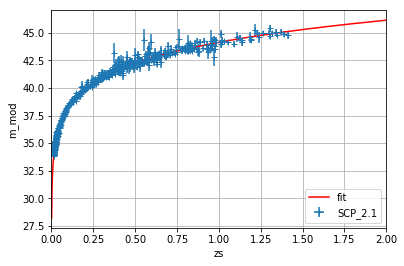

In [14]:
plt.figure()
plt.errorbar(zs,mm,xerr=dz,yerr=dm,fmt='+',label=dlabel)
plt.plot(zz,mc,'r',label='fit')
plt.xlim([0,2.0])
plt.xlabel('zs')
plt.ylabel('m_mod')
plt.grid(b=True,which='major')
plt.grid(b=True,which='minor')
plt.legend(loc='lower right')
plt.show()

<a list of 4 text.Text objects>

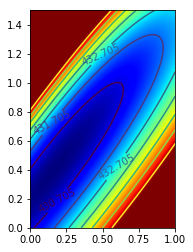

In [15]:
plt.figure()
im = plt.imshow(Z, interpolation='bilinear', origin='lower', \
                cmap=cm.jet, extent=(0.,1.0,0.,1.5))
CS = plt.contour(X, Y, Z)
CS.levels = [chimin+1., chimin+2., chimin+3.]
plt.clabel(CS, CS.levels, inline=1, fontsize=10)

In [28]:
p = lmfit.Parameters()
p.add_many(('OmM', 1), ('OmL', 0),('h',0.7))

def residual(p):
    v = p.valuesdict()
    return data-chisq

In [29]:
mi = lmfit.minimize(residual, p, method='emcee', nan_policy='omit')

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
